<a href="https://colab.research.google.com/github/chvn00/Modelos_Metodos_IA/blob/main/Braille_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📌 Control de versiones

- **Versión:** 1.3.0  
- **Autor:** Dr. Ing. César Hernando Valencia Niño  

---

# 🧠 Clasificación de Lectura Braille con Redes Neuronales

Este cuaderno de trabajo contiene la implementación de cinco arquitecturas de redes neuronales aplicadas a la clasificación de patrones en la escritura Braille digital. Cada modelo permite la modificación de hiperparámetros clave, facilitando el ajuste (*fine-tuning*) para mejorar el rendimiento de clasificación.

---

## ✅ Modelos incluidos

1. **MLP** (Perceptrón Multicapa)
2. **CNN** (Red Neuronal Convolucional)
3. **LSTM** (Red Neuronal Recurrente tipo LSTM)
4. **Transformer**
5. **ESN** (Echo State Network)

---

## 🎯 Objetivo del ejercicio

> Ajustar los hiperparámetros de cada modelo para **maximizar el desempeño en la clasificación multiclase** de los datos de entrada, utilizando métricas de precisión, exhaustividad y puntuación F1.

---

### 📊 Criterios de evaluación

Cada modelo genera automáticamente:
- 📈 **Curva de pérdida** por épocas (`Loss vs Epoch`)
- 📋 **Reporte de clasificación** con métricas `Precision`, `Recall`, `F1-score`
- 🔷 **Matriz de confusión** de d

---

## 🛠️ Hiperparámetros disponibles

Cada modelo incluye una sección editable con variables como:

| Modelo         | Hiperparámetros recomendados para ajustar |
|----------------|-------------------------------------------|
| `MLP`          | `HIDDEN_LAYERS`, `LEARNING_RATE`, `EPOCHS`, `BATCH_SIZE` |
| `CNN`          | `LEARNING_RATE`, `EPOCHS`, `BATCH_SIZE` |
| `LSTM`         | `HIDDEN_DIM`, `NUM_LAYERS`, `LEARNING_RATE`, `EPOCHS` |
| `Transformer`  | `NUM_HEADS`, `HIDDEN_DIM`, `NUM_LAYERS`, `DROPOUT`, `LEARNING_RATE` |
| `ESN`          | `RESERVOIR_SIZE`, `SPECTRAL_RADIUS`, `SPARSITY`, `SEED` |

---

## 📝 Instrucciones

1. Ejecuta cada celda correspondiente a los modelos uno por uno.
2. Ajusta los hiperparámetros hasta obtener el mejor resultado posible para cada red.
3. Analiza y compara el rendimiento de cada arquitectura basada en las salidas del modelo.
4. Genera un informe académico que incluya para **cada modelo**:
   - Hiperparámetros utilizados
   - Figuras de pérdida, clasificación y confusión
   - Justificación técnica de por qué ese modelo y configuración fueron los más efectivos
5. Entrega final:
   - Un archivo `.ipynb` con el código ajustado
   - El informe en PDF o DOCX
   - Envía ambos documentos al correo **cvalencian@correo.uts.edu.co** con el asunto:  
     `Tarea - Clasificación Braille - [Tu Nombre Completo]`

---



In [ ]:
import numpy as np
import pandas as pd

# Generar base de datos balanceada
def generate_balanced_data(samples_per_class=5000):
    data = []

    print(f"Generando {samples_per_class} muestras por clase...")

    # Clase 0 (Mangold's): errores > 3
    for _ in range(samples_per_class):
        correct_matrix = np.random.randint(0, 2, (2, 3)).flatten()
        realized_matrix = correct_matrix.copy()
        for i in range(len(realized_matrix)):
            if np.random.rand() < 0.5:
                realized_matrix[i] = 1 - realized_matrix[i]
        errors = np.sum(correct_matrix != realized_matrix)
        time_response = np.random.uniform(6, 10)
        difficulty = np.random.randint(1, 4)
        feature = np.concatenate([correct_matrix, realized_matrix, [errors, time_response, difficulty]])
        data.append((feature, 0))

    # Clase 1 (ABKL): tiempo alto, errores bajos
    for _ in range(samples_per_class):
        correct_matrix = np.random.randint(0, 2, (2, 3)).flatten()
        realized_matrix = correct_matrix.copy()
        for i in range(len(realized_matrix)):
            if np.random.rand() < 0.2:
                realized_matrix[i] = 1 - realized_matrix[i]
        errors = np.sum(correct_matrix != realized_matrix)
        time_response = np.random.uniform(6, 10)
        difficulty = np.random.randint(1, 4)
        feature = np.concatenate([correct_matrix, realized_matrix, [errors, time_response, difficulty]])
        data.append((feature, 1))

    # Clase 2 (Progresar): tiempo bajo, errores bajos
    for _ in range(samples_per_class):
        correct_matrix = np.random.randint(0, 2, (2, 3)).flatten()
        realized_matrix = correct_matrix.copy()
        for i in range(len(realized_matrix)):
            if np.random.rand() < 0.1:
                realized_matrix[i] = 1 - realized_matrix[i]
        errors = np.sum(correct_matrix != realized_matrix)
        time_response = np.random.uniform(3, 5)
        difficulty = np.random.randint(1, 4)
        feature = np.concatenate([correct_matrix, realized_matrix, [errors, time_response, difficulty]])
        data.append((feature, 2))

    total_samples = len(data)
    print(f"Total de muestras generadas: {total_samples} (3 clases x {samples_per_class} cada una)\n")
    return pd.DataFrame(data, columns=["Features", "Label"])

# Guardar CSV
def save_data_to_csv(file_path="balanced_braille_data.csv"):
    df = generate_balanced_data(500)
    df["Features"] = df["Features"].apply(lambda x: list(x))
    df.to_csv(file_path, index=False)
    print(f"Base de datos guardada como: {file_path}")

# Ejecutar
if __name__ == "__main__":
    save_data_to_csv()


Generando 500 muestras por clase...
Total de muestras generadas: 1500 (3 clases x 500 cada una)

Base de datos guardada como: balanced_braille_data.csv


In [ ]:
# @title Código para entrenar la MLP con hiperparámetros ajustables

# === Hiperparámetros configurables ===
FILE_PATH = "balanced_braille_data.csv"
BATCH_SIZE = 32
HIDDEN_LAYERS = [128, 256, 256, 256, 128]
LEARNING_RATE = 0.01
EPOCHS = 20
NUM_CLASSES = 3
RANDOM_STATE = 42
TEST_SIZE = 0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Librerías ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Preparar los datos ===
def prepare_data(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values
    return X, y

# === Definir el modelo MLP ===
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(MLPModel, self).__init__()
        layers = []
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# === Entrenamiento ===
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

# === Evaluación ===
def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
    return np.array(all_labels), np.array(all_preds)

# === Visualización ===
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.title("Curva de Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# === Flujo Principal ===
def main():
    df = pd.read_csv(FILE_PATH)
    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

    # Tensores
    X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

    # Modelo
    input_dim = X_train.shape[1]
    model = MLPModel(input_dim, HIDDEN_LAYERS, NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Entrenando modelo MLP...")
    train_losses = train_model(model, train_loader, optimizer, criterion, device=DEVICE, epochs=EPOCHS)
    plot_loss_curve(train_losses)

    print("Evaluando modelo...")
    y_train_true, y_train_pred = evaluate_model(model, train_loader, device=DEVICE)
    y_test_true, y_test_pred = evaluate_model(model, test_loader, device=DEVICE)

    print("Reporte de Clasificación - Entrenamiento")
    print(classification_report(y_train_true, y_train_pred))
    plot_confusion_matrix(y_train_true, y_train_pred, classes=CLASSES, title="Matriz de Confusión - Entrenamiento")

    print("Reporte de Clasificación - Prueba")
    print(classification_report(y_test_true, y_test_pred))
    plot_confusion_matrix(y_test_true, y_test_pred, classes=CLASSES, title="Matriz de Confusión - Prueba")

if __name__ == "__main__":
    main()


NameError: name 'torch' is not defined

In [ ]:
# @title Código para entrenar una CNN con hiperparámetros ajustables

# === Hiperparámetros configurables ===
FILE_PATH = "balanced_braille_data.csv"
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 20
NUM_CLASSES = 3
TEST_SIZE = 0.2
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Librerías ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Preparar los datos ===
def prepare_data_for_cnn(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values

    original_matrices = X[:, :6].reshape(-1, 1, 2, 3)
    digitized_matrices = X[:, 6:12].reshape(-1, 1, 2, 3)
    auxiliary_features = X[:, 12:14]

    X_cnn = np.concatenate([original_matrices, digitized_matrices], axis=1)
    print(f"Dimensiones finales de X para la CNN: {X_cnn.shape}")
    print(f"Dimensiones de y: {y.shape}")
    return X_cnn, auxiliary_features, y

# === Definir modelo CNN ===
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=(1, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(1, 2), stride=1, padding=0),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 + 2, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, aux):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = torch.cat((x, aux), dim=1)
        return self.fc_layers(x)

# === Entrenamiento ===
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for features, aux_features, labels in train_loader:
            features, aux_features, labels = features.to(device), aux_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features, aux_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

# === Evaluación ===
def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, aux_features, labels in loader:
            features, aux_features, labels = features.to(device), aux_features.to(device), labels.to(device)
            outputs = model(features, aux_features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
    return np.array(all_labels), np.array(all_preds)

# === Visualización ===
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.title("Curva de Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# === Flujo Principal ===
def main():
    df = pd.read_csv(FILE_PATH)
    print(f"Datos cargados: {df.shape}")

    X_cnn, aux_features, y = prepare_data_for_cnn(df)

    X_train, X_test, aux_train, aux_test, y_train, y_test = train_test_split(
        X_cnn, aux_features, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    aux_train = torch.tensor(aux_train, dtype=torch.float32)
    aux_test = torch.tensor(aux_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(X_train, aux_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, aux_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNModel(NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Entrenando modelo CNN...")
    train_losses = train_model(model, train_loader, optimizer, criterion, DEVICE, EPOCHS)
    plot_loss_curve(train_losses)

    print("Evaluando modelo...")
    y_train_true, y_train_pred = evaluate_model(model, train_loader, DEVICE)
    y_test_true, y_test_pred = evaluate_model(model, test_loader, DEVICE)

    print("Reporte de Clasificación - Entrenamiento")
    print(classification_report(y_train_true, y_train_pred))
    plot_confusion_matrix(y_train_true, y_train_pred, classes=CLASSES, title="Matriz de Confusión - Entrenamiento")

    print("Reporte de Clasificación - Prueba")
    print(classification_report(y_test_true, y_test_pred))
    plot_confusion_matrix(y_test_true, y_test_pred, classes=CLASSES, title="Matriz de Confusión - Prueba")

if __name__ == "__main__":
    main()


NameError: name 'torch' is not defined

Datos cargados: (1500, 2)
Dimensiones finales de X para la LSTM: (1500, 2, 8)
Dimensiones de y: (1500,)
Entrenando modelo LSTM...
Epoch 1/20, Loss: 0.6061
Epoch 2/20, Loss: 0.3588
Epoch 3/20, Loss: 0.3755
Epoch 4/20, Loss: 0.3713
Epoch 5/20, Loss: 0.3216
Epoch 6/20, Loss: 0.3285
Epoch 7/20, Loss: 0.3679
Epoch 8/20, Loss: 0.3389
Epoch 9/20, Loss: 0.4061
Epoch 10/20, Loss: 0.3317
Epoch 11/20, Loss: 0.3140
Epoch 12/20, Loss: 0.3203
Epoch 13/20, Loss: 0.3239
Epoch 14/20, Loss: 0.3189
Epoch 15/20, Loss: 0.3198
Epoch 16/20, Loss: 0.3107
Epoch 17/20, Loss: 0.3158
Epoch 18/20, Loss: 0.3043
Epoch 19/20, Loss: 0.3043
Epoch 20/20, Loss: 0.3019


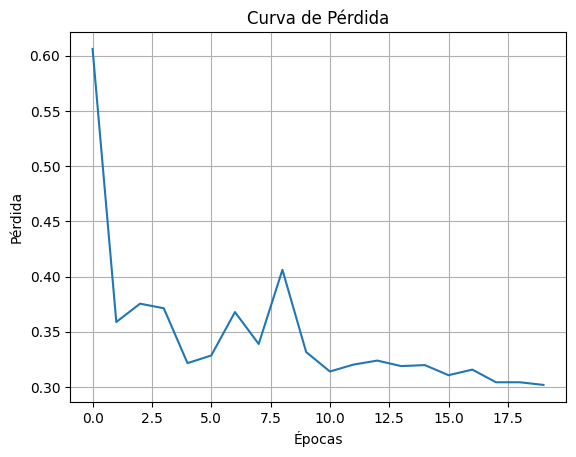

Evaluando modelo...
Reporte de Clasificación - Entrenamiento
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       400
           1       0.82      0.78      0.80       400
           2       1.00      1.00      1.00       400

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



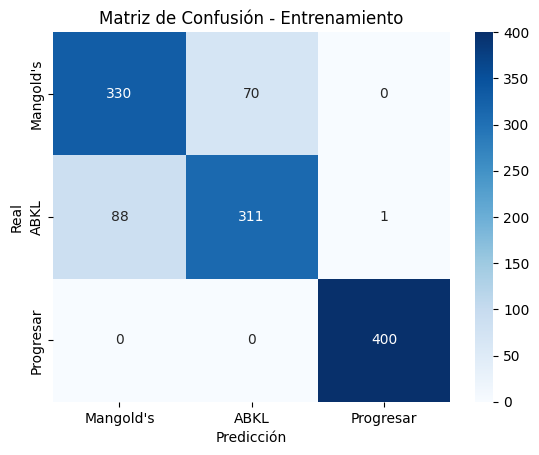

Reporte de Clasificación - Prueba
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       100
           1       0.73      0.72      0.73       100
           2       1.00      1.00      1.00       100

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



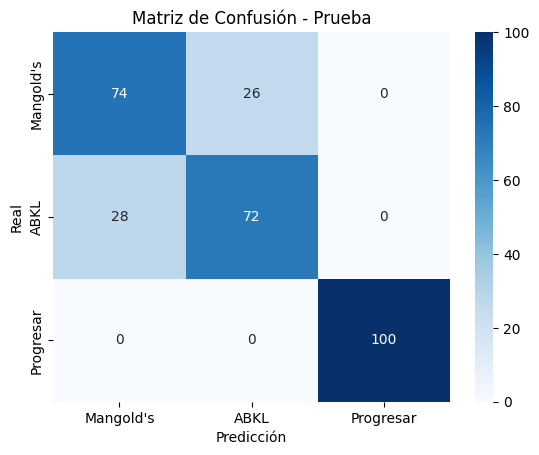

In [ ]:
# @title Código para entrenar una LSTM con hiperparámetros ajustables

# === Hiperparámetros configurables ===
FILE_PATH = "balanced_braille_data.csv"
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 20
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_CLASSES = 3
TEST_SIZE = 0.2
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Librerías ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Preparar los datos ===
def prepare_data_for_lstm(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values

    braille_matrices = X[:, :12].reshape(-1, 2, 6)
    auxiliary_features = X[:, 12:14]
    auxiliary_features_expanded = np.repeat(auxiliary_features[:, None, :], 2, axis=1)

    X_lstm = np.concatenate([braille_matrices, auxiliary_features_expanded], axis=2)

    print(f"Dimensiones finales de X para la LSTM: {X_lstm.shape}")
    print(f"Dimensiones de y: {y.shape}")
    return X_lstm, y

# === Definir modelo LSTM ===
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        x = hidden[-1]
        x = self.fc(x)
        return x

# === Entrenamiento ===
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

# === Evaluación ===
def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
    return np.array(all_labels), np.array(all_preds)

# === Visualización ===
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.title("Curva de Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# === Flujo Principal ===
def main():
    df = pd.read_csv(FILE_PATH)
    print(f"Datos cargados: {df.shape}")

    X_lstm, y = prepare_data_for_lstm(df)

    X_train, X_test, y_train, y_test = train_test_split(
        X_lstm, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    input_dim = X_train.shape[2]
    model = LSTMModel(input_dim, HIDDEN_DIM, NUM_LAYERS, NUM_CLASSES).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Entrenando modelo LSTM...")
    train_losses = train_model(model, train_loader, optimizer, criterion, DEVICE, EPOCHS)
    plot_loss_curve(train_losses)

    print("Evaluando modelo...")
    y_train_true, y_train_pred = evaluate_model(model, train_loader, DEVICE)
    y_test_true, y_test_pred = evaluate_model(model, test_loader, DEVICE)

    print("Reporte de Clasificación - Entrenamiento")
    print(classification_report(y_train_true, y_train_pred))
    plot_confusion_matrix(y_train_true, y_train_pred, classes=CLASSES, title="Matriz de Confusión - Entrenamiento")

    print("Reporte de Clasificación - Prueba")
    print(classification_report(y_test_true, y_test_pred))
    plot_confusion_matrix(y_test_true, y_test_pred, classes=CLASSES, title="Matriz de Confusión - Prueba")

if __name__ == "__main__":
    main()


Datos cargados: (1500, 2)
Dimensiones finales de X para el Transformer: (1500, 2, 8)
Dimensiones de y: (1500,)
Entrenando modelo Transformer...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.6098
Epoch 2/20, Loss: 0.3458
Epoch 3/20, Loss: 0.3538
Epoch 4/20, Loss: 0.3489
Epoch 5/20, Loss: 0.3767
Epoch 6/20, Loss: 0.3465
Epoch 7/20, Loss: 0.3815
Epoch 8/20, Loss: 0.3395
Epoch 9/20, Loss: 0.4051
Epoch 10/20, Loss: 0.3349
Epoch 11/20, Loss: 0.4007
Epoch 12/20, Loss: 0.3835
Epoch 13/20, Loss: 0.3872
Epoch 14/20, Loss: 0.3424
Epoch 15/20, Loss: 0.3223
Epoch 16/20, Loss: 0.3141
Epoch 17/20, Loss: 0.3232
Epoch 18/20, Loss: 0.3192
Epoch 19/20, Loss: 0.3830
Epoch 20/20, Loss: 0.3442


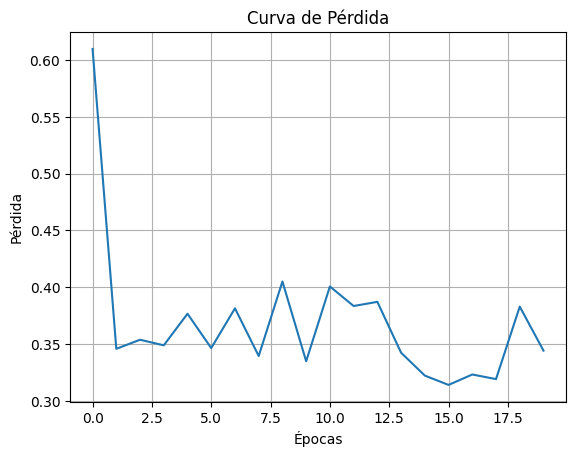

Evaluando modelo...
Reporte de Clasificación - Entrenamiento
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       400
           1       0.85      0.64      0.73       400
           2       1.00      1.00      1.00       400

    accuracy                           0.84      1200
   macro avg       0.85      0.84      0.84      1200
weighted avg       0.85      0.84      0.84      1200



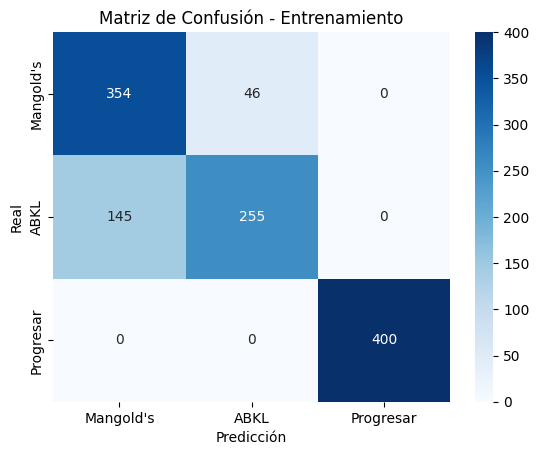

Reporte de Clasificación - Prueba
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       100
           1       0.80      0.65      0.72       100
           2       1.00      1.00      1.00       100

    accuracy                           0.83       300
   macro avg       0.84      0.83      0.83       300
weighted avg       0.84      0.83      0.83       300



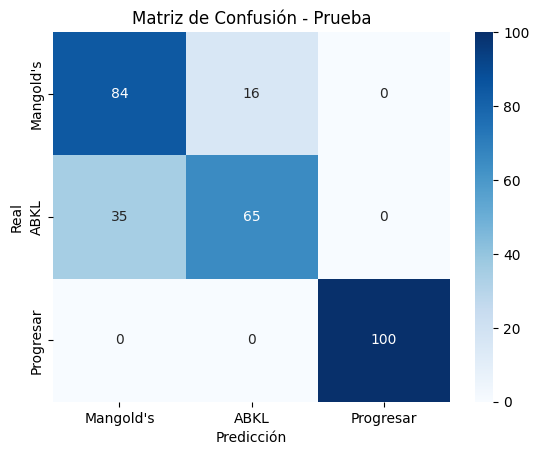

In [ ]:
# @title Código para entrenar un Transformer con hiperparámetros ajustables

# === Hiperparámetros configurables ===
FILE_PATH = "balanced_braille_data.csv"
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
HIDDEN_DIM = 64
NUM_HEADS = 4
NUM_LAYERS = 2
NUM_CLASSES = 3
DROPOUT = 0.1
TEST_SIZE = 0.2
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Librerías ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Preparar los datos ===
def prepare_data_for_transformer(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values

    braille_matrices = X[:, :12].reshape(-1, 2, 6)
    auxiliary_features = X[:, 12:14]
    auxiliary_features_expanded = np.repeat(auxiliary_features[:, None, :], 2, axis=1)

    X_transformer = np.concatenate([braille_matrices, auxiliary_features_expanded], axis=2)
    print(f"Dimensiones finales de X para el Transformer: {X_transformer.shape}")
    print(f"Dimensiones de y: {y.shape}")
    return X_transformer, y

# === Definir modelo Transformer ===
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 2, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# === Entrenamiento ===
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

# === Evaluación ===
def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
    return np.array(all_labels), np.array(all_preds)

# === Visualización ===
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.title("Curva de Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# === Flujo Principal ===
def main():
    df = pd.read_csv(FILE_PATH)
    print(f"Datos cargados: {df.shape}")

    X_transformer, y = prepare_data_for_transformer(df)

    X_train, X_test, y_train, y_test = train_test_split(
        X_transformer, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    input_dim = X_train.shape[2]
    model = TransformerModel(input_dim, NUM_HEADS, NUM_LAYERS, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Entrenando modelo Transformer...")
    train_losses = train_model(model, train_loader, optimizer, criterion, DEVICE, EPOCHS)
    plot_loss_curve(train_losses)

    print("Evaluando modelo...")
    y_train_true, y_train_pred = evaluate_model(model, train_loader, DEVICE)
    y_test_true, y_test_pred = evaluate_model(model, test_loader, DEVICE)

    print("Reporte de Clasificación - Entrenamiento")
    print(classification_report(y_train_true, y_train_pred))
    plot_confusion_matrix(y_train_true, y_train_pred, classes=CLASSES, title="Matriz de Confusión - Entrenamiento")

    print("Reporte de Clasificación - Prueba")
    print(classification_report(y_test_true, y_test_pred))
    plot_confusion_matrix(y_test_true, y_test_pred, classes=CLASSES, title="Matriz de Confusión - Prueba")

if __name__ == "__main__":
    main()


Datos cargados: (1500, 2)
Dimensiones finales de X para la ESN: (1500, 14)
Dimensiones de y: (1500,)
Entrenando modelo ESN...
Evaluando modelo...
Reporte de Clasificación - Entrenamiento
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       400
           1       0.84      0.83      0.84       400
           2       1.00      1.00      1.00       400

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



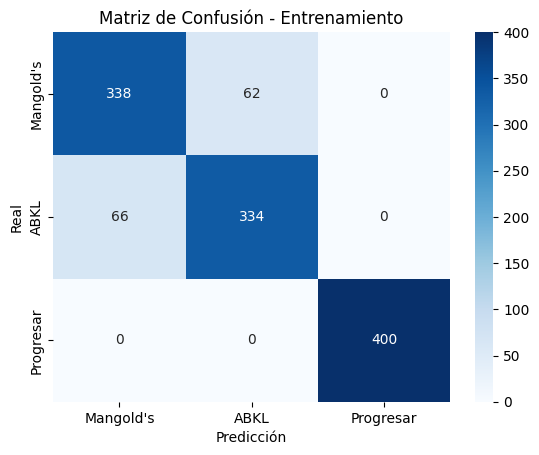

Reporte de Clasificación - Prueba
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       100
           1       0.77      0.76      0.76       100
           2       0.99      0.99      0.99       100

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



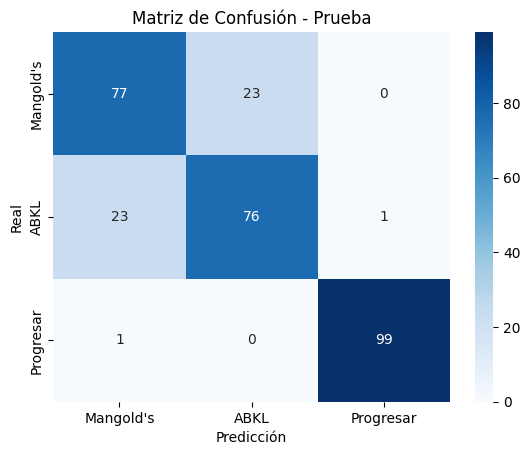

In [ ]:
# @title Código para entrenar una ESN con hiperparámetros ajustables

# === Hiperparámetros configurables ===
FILE_PATH = "balanced_braille_data.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42
RESERVOIR_SIZE = 500
SPECTRAL_RADIUS = 0.95
SPARSITY = 0.1
SEED = 42
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Librerías ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import RidgeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# === Preparar datos ===
def prepare_data_for_esn(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values
    braille_matrices = X[:, :12].reshape(-1, 12)
    auxiliary_features = X[:, 12:14]
    X_esn = np.concatenate([braille_matrices, auxiliary_features], axis=1)
    print(f"Dimensiones finales de X para la ESN: {X_esn.shape}")
    print(f"Dimensiones de y: {y.shape}")
    return X_esn, y

# === Definir ESN ===
class ESN:
    def __init__(self, input_dim, reservoir_size, spectral_radius=0.95, sparsity=0.1, seed=None):
        self.input_dim = input_dim
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.seed = seed
        self.W_in = None
        self.W = None

    def initialize_reservoir(self):
        rng = np.random.default_rng(self.seed)
        self.W_in = rng.uniform(-1, 1, (self.reservoir_size, self.input_dim))
        W = rng.uniform(-1, 1, (self.reservoir_size, self.reservoir_size))
        W *= rng.random(W.shape) < self.sparsity
        spectral_radius = max(abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / spectral_radius)

    def fit(self, X, y):
        self.initialize_reservoir()
        reservoir_states = self.compute_reservoir_states(X)
        self.readout = RidgeClassifier(alpha=1.0)
        self.readout.fit(reservoir_states, y)

    def predict(self, X):
        reservoir_states = self.compute_reservoir_states(X)
        return self.readout.predict(reservoir_states)

    def compute_reservoir_states(self, X):
        num_samples = X.shape[0]
        reservoir_states = np.zeros((num_samples, self.reservoir_size))
        for i in range(num_samples):
            u = X[i]
            x = np.zeros(self.reservoir_size)
            x = np.tanh(np.dot(self.W_in, u) + np.dot(self.W, x))
            reservoir_states[i] = x
        return reservoir_states

# === Visualización ===
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# === Flujo Principal ===
def main():
    df = pd.read_csv(FILE_PATH)
    print(f"Datos cargados: {df.shape}")
    X, y = prepare_data_for_esn(df)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    input_dim = X_train.shape[1]
    esn = ESN(
        input_dim=input_dim,
        reservoir_size=RESERVOIR_SIZE,
        spectral_radius=SPECTRAL_RADIUS,
        sparsity=SPARSITY,
        seed=SEED
    )

    print("Entrenando modelo ESN...")
    esn.fit(X_train, y_train)

    print("Evaluando modelo...")
    y_train_pred = esn.predict(X_train)
    y_test_pred = esn.predict(X_test)

    print("Reporte de Clasificación - Entrenamiento")
    print(classification_report(y_train, y_train_pred))
    plot_confusion_matrix(y_train, y_train_pred, classes=CLASSES, title="Matriz de Confusión - Entrenamiento")

    print("Reporte de Clasificación - Prueba")
    print(classification_report(y_test, y_test_pred))
    plot_confusion_matrix(y_test, y_test_pred, classes=CLASSES, title="Matriz de Confusión - Prueba")

if __name__ == "__main__":
    main()


Entrenando modelo SVM...

Reporte de Clasificación - Entrenamiento
              precision    recall  f1-score   support

   Mangold's       0.81      0.85      0.83       400
        ABKL       0.84      0.80      0.82       400
   Progresar       1.00      1.00      1.00       400

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



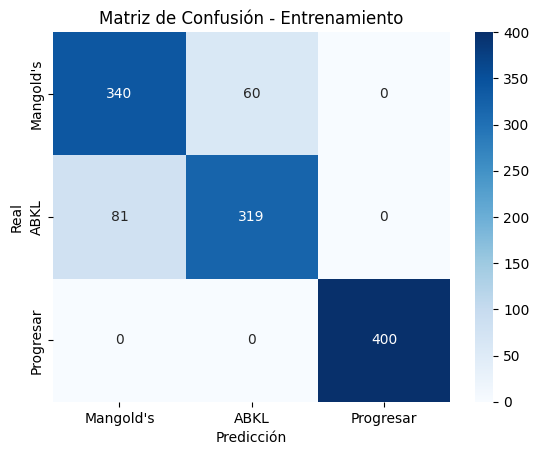


Reporte de Clasificación - Prueba
              precision    recall  f1-score   support

   Mangold's       0.76      0.81      0.79       100
        ABKL       0.80      0.75      0.77       100
   Progresar       1.00      1.00      1.00       100

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



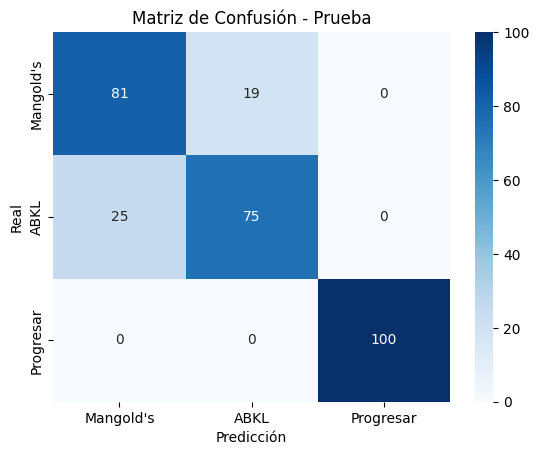

In [ ]:
# @title Código para entrenar una SVM con visualización y métricas

# === Hiperparámetros de SVM ===
FILE_PATH = "balanced_braille_data.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# Hiperparámetros del modelo SVM
SVM_KERNEL = "rbf"         # Opciones: "linear", "rbf", "poly", "sigmoid"
SVM_C = 1.0                # Penalización por error (entre 0.1 y 1000, por ejemplo)
SVM_GAMMA = "scale"        # Opciones: "scale", "auto", o un valor numérico como 0.01

# === Librerías ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Preparar los datos ===
def prepare_data(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values
    return X, y

# === Visualización ===
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# === Flujo Principal ===
def main():
    # Cargar y preparar los datos
    df = pd.read_csv(FILE_PATH)
    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # Entrenar SVM
    print("Entrenando modelo SVM...")
    model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    model.fit(X_train, y_train)

    # Evaluación
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("\nReporte de Clasificación - Entrenamiento")
    print(classification_report(y_train, y_train_pred, target_names=CLASSES))
    plot_confusion_matrix(y_train, y_train_pred, CLASSES, title="Matriz de Confusión - Entrenamiento")

    print("\nReporte de Clasificación - Prueba")
    print(classification_report(y_test, y_test_pred, target_names=CLASSES))
    plot_confusion_matrix(y_test, y_test_pred, CLASSES, title="Matriz de Confusión - Prueba")

if __name__ == "__main__":
    main()

Cargando datos...
Buscando la mejor combinación de hiperparámetros...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Mejores parámetros encontrados: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Reporte de Clasificación - Entrenamiento
              precision    recall  f1-score   support

   Mangold's       0.83      0.85      0.84       400
        ABKL       0.85      0.82      0.83       400
   Progresar       1.00      1.00      1.00       400

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



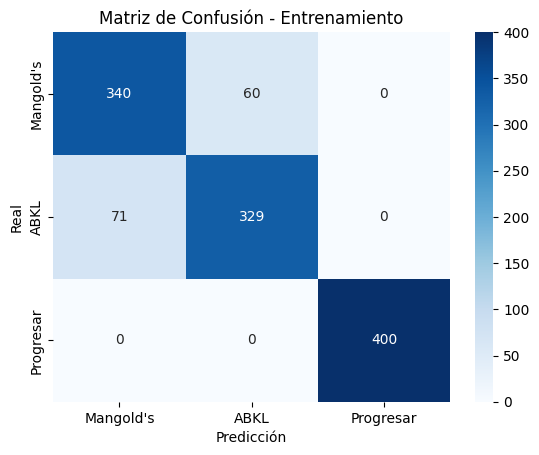


Reporte de Clasificación - Prueba
              precision    recall  f1-score   support

   Mangold's       0.78      0.79      0.79       100
        ABKL       0.79      0.78      0.78       100
   Progresar       1.00      1.00      1.00       100

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



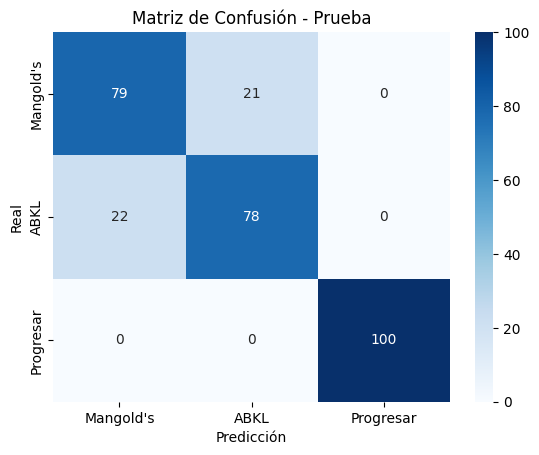

In [ ]:
# @title Entrenamiento de SVM con ajuste automático de hiperparámetros

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Configuración básica ===
FILE_PATH = "balanced_braille_data.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Preparar los datos ===
def prepare_data(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values
    return X, y

# === Visualización ===
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# === Flujo Principal ===
def main():
    print("Cargando datos...")
    df = pd.read_csv(FILE_PATH)
    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # === Definir la grilla de búsqueda ===
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }

    print("Buscando la mejor combinación de hiperparámetros...")
    grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    # === Evaluar ===
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    print("\nReporte de Clasificación - Entrenamiento")
    print(classification_report(y_train, y_train_pred, target_names=CLASSES))
    plot_confusion_matrix(y_train, y_train_pred, CLASSES, "Matriz de Confusión - Entrenamiento")

    print("\nReporte de Clasificación - Prueba")
    print(classification_report(y_test, y_test_pred, target_names=CLASSES))
    plot_confusion_matrix(y_test, y_test_pred, CLASSES, "Matriz de Confusión - Prueba")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Entrenando modelo TabNet...
epoch 0  | loss: 1.3459  | train_accuracy: 0.41083 | valid_accuracy: 0.35667 |  0:00:00s
epoch 1  | loss: 1.02415 | train_accuracy: 0.51917 | valid_accuracy: 0.48333 |  0:00:00s
epoch 2  | loss: 0.8618  | train_accuracy: 0.5775  | valid_accuracy: 0.52333 |  0:00:01s
epoch 3  | loss: 0.77138 | train_accuracy: 0.63333 | valid_accuracy: 0.58333 |  0:00:01s
epoch 4  | loss: 0.66411 | train_accuracy: 0.6575  | valid_accuracy: 0.63333 |  0:00:01s
epoch 5  | loss: 0.58557 | train_accuracy: 0.6825  | valid_accuracy: 0.63667 |  0:00:02s
epoch 6  | loss: 0.50455 | train_accuracy: 0.71417 | valid_accuracy: 0.67667 |  0:00:02s
epoch 7  | loss: 0.44426 | train_accuracy: 0.74    | valid_accuracy: 0.71667 |  0:00:03s
epoch 8  | loss: 0.42238 | train_accuracy: 0.80333 | valid_accuracy: 0.77333 |  0:00:03s
epoch 9  | loss: 0.38256 | train_accuracy: 0.81083 | valid_accuracy: 0.78333 |  0:00:04s
epoch 10 | loss: 0.35836 | train_accuracy: 0.83083 | valid_accuracy: 0.77    |  0:

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


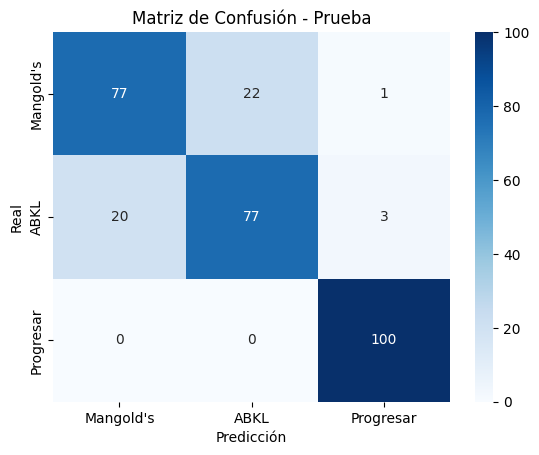

In [ ]:
# @title Clasificación con TabNet (PyTorch)

#!pip install pytorch-tabnet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# === Configuración ===
FILE_PATH = "balanced_braille_data.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Cargar y preparar datos ===
def prepare_data(df):
    X = np.stack(df["Features"].apply(eval).values)
    y = df["Label"].values
    return X, y

df = pd.read_csv(FILE_PATH)
X, y = prepare_data(df)

# Escalar (opcional pero recomendable para TabNet)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Codificar etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Dividir
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# === Entrenar TabNet ===
clf = TabNetClassifier(
    seed=RANDOM_STATE,
    verbose=1,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

print("Entrenando modelo TabNet...")
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
)

# === Predicción ===
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# === Reportes ===
print("\nReporte de Clasificación - Entrenamiento")
print(classification_report(y_train, y_train_pred, target_names=CLASSES))

print("\nReporte de Clasificación - Prueba")
print(classification_report(y_test, y_test_pred, target_names=CLASSES))

# === Matriz de confusión ===
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

plot_confusion_matrix(y_test, y_test_pred, CLASSES, "Matriz de Confusión - Prueba")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Entrenando modelo TabNet con features mejoradas...
epoch 0  | loss: 1.27794 | train_accuracy: 0.43917 | valid_accuracy: 0.44    |  0:00:00s
epoch 1  | loss: 0.93531 | train_accuracy: 0.51333 | valid_accuracy: 0.54    |  0:00:00s
epoch 2  | loss: 0.82215 | train_accuracy: 0.625   | valid_accuracy: 0.64333 |  0:00:00s
epoch 3  | loss: 0.70922 | train_accuracy: 0.62417 | valid_accuracy: 0.68667 |  0:00:00s
epoch 4  | loss: 0.62403 | train_accuracy: 0.66833 | valid_accuracy: 0.70667 |  0:00:00s
epoch 5  | loss: 0.52609 | train_accuracy: 0.74    | valid_accuracy: 0.79    |  0:00:00s
epoch 6  | loss: 0.46597 | train_accuracy: 0.7825  | valid_accuracy: 0.78333 |  0:00:01s
epoch 7  | loss: 0.37969 | train_accuracy: 0.80333 | valid_accuracy: 0.79667 |  0:00:01s
epoch 8  | loss: 0.38851 | train_accuracy: 0.82083 | valid_accuracy: 0.83    |  0:00:01s
epoch 9  | loss: 0.35    | train_accuracy: 0.83917 | valid_accuracy: 0.82333 |  0:00:01s
epoch 10 | loss: 0.32338 | train_accuracy: 0.85    | valid_

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


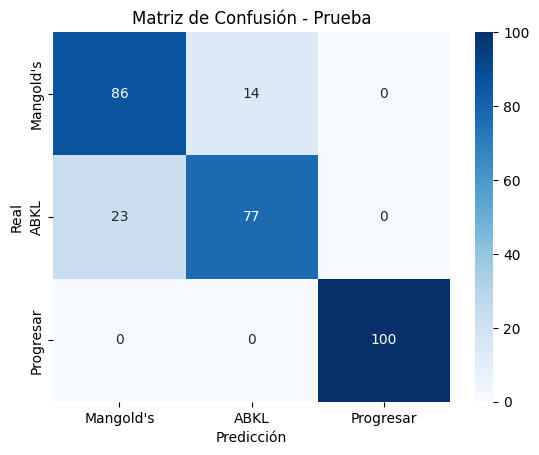

In [ ]:
# @title Reentrenamiento TabNet con nuevas features derivadas

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# === Configuración ===
FILE_PATH = "balanced_braille_data.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Preparar los datos con nuevas features ===
def prepare_enhanced_data(df):
    X_raw = np.stack(df["Features"].apply(eval).values)

    # Separar los datos originales
    correct_matrix = X_raw[:, 0:6]
    realized_matrix = X_raw[:, 6:12]
    errors = X_raw[:, 12]
    time = X_raw[:, 13]
    difficulty = X_raw[:, 14]

    # === Nuevas features derivadas ===
    error_rate = errors / 6
    time_per_difficulty = time / difficulty
    similarity_score = np.sum(correct_matrix == realized_matrix, axis=1) / 6

    # Concatenar todo
    X_enhanced = np.hstack((X_raw,
                            error_rate.reshape(-1, 1),
                            time_per_difficulty.reshape(-1, 1),
                            similarity_score.reshape(-1, 1)))

    y = df["Label"].values
    return X_enhanced, y

# === Cargar y preparar ===
df = pd.read_csv(FILE_PATH)
X, y = prepare_enhanced_data(df)

# Escalado
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Codificar etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# División
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# === Modelo TabNet ===
clf = TabNetClassifier(
    seed=RANDOM_STATE,
    verbose=1,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

print("Entrenando modelo TabNet con features mejoradas...")
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
)

# === Evaluación ===
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("\n📊 Reporte de Clasificación - Entrenamiento")
print(classification_report(y_train, y_train_pred, target_names=CLASSES))

print("\n📊 Reporte de Clasificación - Prueba")
print(classification_report(y_test, y_test_pred, target_names=CLASSES))

# === Matriz de confusión ===
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

plot_confusion_matrix(y_test, y_test_pred, CLASSES, "Matriz de Confusión - Prueba")


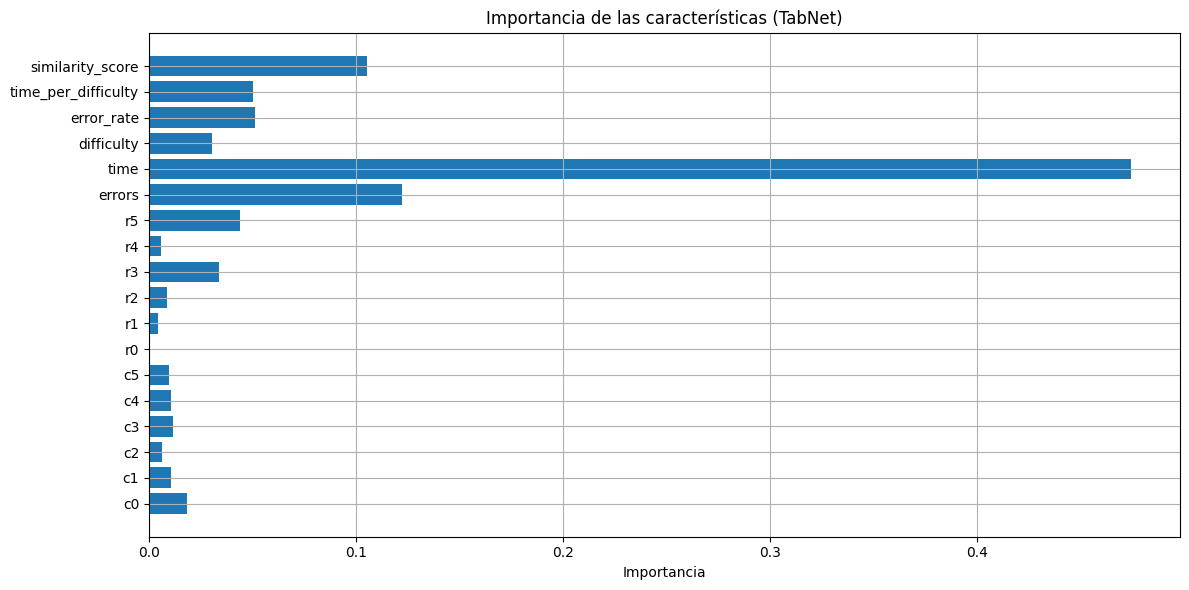

In [ ]:
import matplotlib.pyplot as plt

feature_names = [
    "c0", "c1", "c2", "c3", "c4", "c5",              # x0–x5 correct_matrix
    "r0", "r1", "r2", "r3", "r4", "r5",              # x6–x11 realized_matrix
    "errors", "time", "difficulty",                 # x12–x14
    "error_rate", "time_per_difficulty", "similarity_score"  # x15–x17
]

importances = clf.feature_importances_
plt.figure(figsize=(12, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importancia")
plt.title("Importancia de las características (TabNet)")
plt.grid(True)
plt.tight_layout()
plt.show()



Early stopping occurred at epoch 21 with best_epoch = 11 and best_valid_accuracy = 1.0


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_valid_accuracy = 0.78


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



📊 Reporte de Clasificación - Prueba Final
              precision    recall  f1-score   support

   Mangold's       0.73      0.88      0.80       100
        ABKL       0.85      0.68      0.76       100
   Progresar       1.00      1.00      1.00       100

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



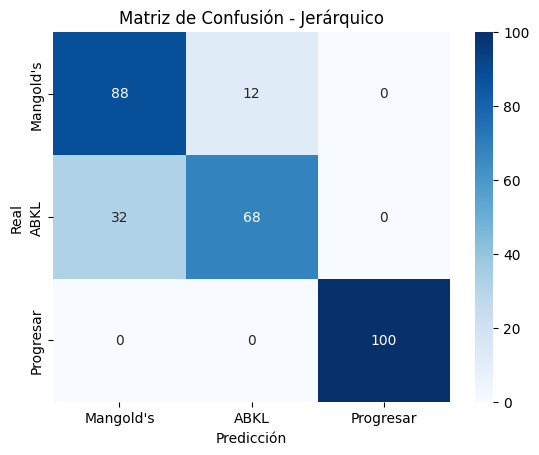

In [ ]:
# @title Modelo Jerárquico con TabNet para Clasificación Braille

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuración ===
FILE_PATH = "balanced_braille_data.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Preparar los datos con features mejoradas ===
def prepare_data(df):
    X_raw = np.stack(df["Features"].apply(eval).values)
    correct_matrix = X_raw[:, 0:6]
    realized_matrix = X_raw[:, 6:12]
    errors = X_raw[:, 12]
    time = X_raw[:, 13]
    difficulty = X_raw[:, 14]

    error_rate = errors / 6
    time_per_difficulty = time / difficulty
    similarity_score = np.sum(correct_matrix == realized_matrix, axis=1) / 6

    X_enhanced = np.hstack((X_raw,
                            error_rate.reshape(-1, 1),
                            time_per_difficulty.reshape(-1, 1),
                            similarity_score.reshape(-1, 1)))

    y = df["Label"].values
    return X_enhanced, y

df = pd.read_csv(FILE_PATH)
X, y = prepare_data(df)

# Escalar
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Separar conjuntos ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# === ETAPA 1: Progresar (2) vs No-Progresar (0,1) ===
y_train_stage1 = (y_train == 2).astype(int)  # 1 = Progresar
y_test_stage1 = (y_test == 2).astype(int)

clf_stage1 = TabNetClassifier(seed=RANDOM_STATE, verbose=0, device_name='cuda' if torch.cuda.is_available() else 'cpu')
clf_stage1.fit(X_train, y_train_stage1,
               eval_set=[(X_train, y_train_stage1), (X_test, y_test_stage1)],
               eval_name=["train", "valid"],
               eval_metric=["accuracy"],
               max_epochs=100, patience=10, batch_size=256, virtual_batch_size=128)

# === ETAPA 2: Mangold's (0) vs ABKL (1), solo en los No-Progresar ===
mask_train_2 = y_train != 2
mask_test_2 = y_test != 2

X_train_stage2 = X_train[mask_train_2]
y_train_stage2 = y_train[mask_train_2]

X_test_stage2 = X_test[mask_test_2]
y_test_stage2 = y_test[mask_test_2]

clf_stage2 = TabNetClassifier(seed=RANDOM_STATE, verbose=0, device_name='cuda' if torch.cuda.is_available() else 'cpu')
clf_stage2.fit(X_train_stage2, y_train_stage2,
               eval_set=[(X_train_stage2, y_train_stage2), (X_test_stage2, y_test_stage2)],
               eval_name=["train", "valid"],
               eval_metric=["accuracy"],
               max_epochs=100, patience=10, batch_size=256, virtual_batch_size=128)

# === Predicción jerárquica completa ===
y_pred_final = []

for x in X_test:
    pred_stage1 = clf_stage1.predict(x.reshape(1, -1))[0]
    if pred_stage1 == 1:
        y_pred_final.append(2)  # Progresar
    else:
        pred_stage2 = clf_stage2.predict(x.reshape(1, -1))[0]
        y_pred_final.append(pred_stage2)

y_pred_final = np.array(y_pred_final)

# === Reporte y Matriz de Confusión ===
print("\n📊 Reporte de Clasificación - Prueba Final")
print(classification_report(y_test, y_pred_final, target_names=CLASSES))

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

plot_confusion_matrix(y_test, y_pred_final, CLASSES, "Matriz de Confusión - Jerárquico")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31344 | train_accuracy: 0.44917 | valid_accuracy: 0.44667 |  0:00:00s
epoch 1  | loss: 1.037   | train_accuracy: 0.51833 | valid_accuracy: 0.49    |  0:00:00s
epoch 2  | loss: 0.8524  | train_accuracy: 0.59917 | valid_accuracy: 0.59    |  0:00:01s
epoch 3  | loss: 0.78135 | train_accuracy: 0.65583 | valid_accuracy: 0.64667 |  0:00:01s
epoch 4  | loss: 0.68823 | train_accuracy: 0.72583 | valid_accuracy: 0.71    |  0:00:02s
epoch 5  | loss: 0.57519 | train_accuracy: 0.76667 | valid_accuracy: 0.71    |  0:00:02s
epoch 6  | loss: 0.5454  | train_accuracy: 0.7775  | valid_accuracy: 0.75333 |  0:00:03s
epoch 7  | loss: 0.43241 | train_accuracy: 0.80917 | valid_accuracy: 0.79667 |  0:00:04s
epoch 8  | loss: 0.39773 | train_accuracy: 0.8325  | valid_accuracy: 0.81333 |  0:00:04s
epoch 9  | loss: 0.36141 | train_accuracy: 0.83667 | valid_accuracy: 0.82333 |  0:00:04s
epoch 10 | loss: 0.35012 | train_accuracy: 0.84333 | valid_accuracy: 0.82667 |  0:00:04s
epoch 11 | loss: 0.33

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


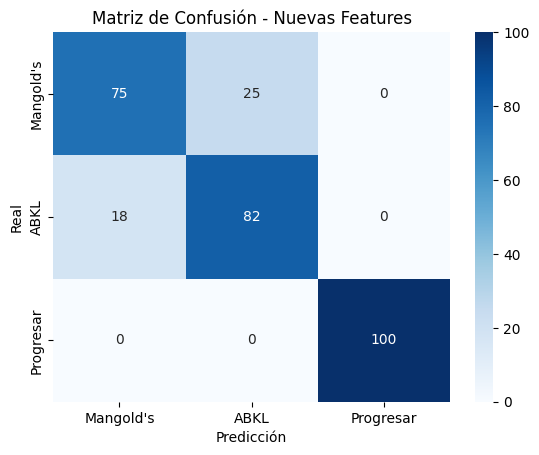

In [ ]:
# @title Reentrenamiento TabNet con nuevas features para ABKL vs Mangold's

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuración ===
FILE_PATH = "balanced_braille_data.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42
CLASSES = ["Mangold's", "ABKL", "Progresar"]

# === Función para agregar nuevas features ===
def prepare_advanced_data(df):
    X_raw = np.stack(df["Features"].apply(eval).values)

    correct = X_raw[:, 0:6]
    realized = X_raw[:, 6:12]
    errors = X_raw[:, 12]
    time = X_raw[:, 13]
    difficulty = X_raw[:, 14]

    # Nuevas features
    error_rate = errors / 6
    similarity_score = np.sum(correct == realized, axis=1) / 6
    time_per_difficulty = time / difficulty

    # Errores específicos
    omission_errors = np.sum((correct == 1) & (realized == 0), axis=1)
    addition_errors = np.sum((correct == 0) & (realized == 1), axis=1)
    omission_ratio = omission_errors / np.clip(np.sum(correct, axis=1), 1, None)
    addition_ratio = addition_errors / np.clip(6 - np.sum(correct, axis=1), 1, None)
    error_balance_ratio = omission_errors / (addition_errors + 1e-5)
    time_per_error = time / (errors + 1)
    activation_density = np.sum(realized, axis=1) / 6
    speed_score = 1 / time

    # Concatenar todo
    X_enhanced = np.hstack((
        X_raw,
        error_rate.reshape(-1, 1),
        similarity_score.reshape(-1, 1),
        time_per_difficulty.reshape(-1, 1),
        omission_errors.reshape(-1, 1),
        addition_errors.reshape(-1, 1),
        error_balance_ratio.reshape(-1, 1),
        time_per_error.reshape(-1, 1),
        activation_density.reshape(-1, 1),
        speed_score.reshape(-1, 1)
    ))

    y = df["Label"].values
    return X_enhanced, y

# === Cargar y preparar datos ===
df = pd.read_csv(FILE_PATH)
X, y = prepare_advanced_data(df)

# Escalado
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Codificar etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# División
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# === Entrenar TabNet ===
clf = TabNetClassifier(
    seed=RANDOM_STATE,
    verbose=1,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
)

# === Evaluación ===
y_pred = clf.predict(X_test)
print("\n📊 Reporte de Clasificación - Prueba con nuevas features")
print(classification_report(y_test, y_pred, target_names=CLASSES))

# === Matriz de Confusión ===
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

plot_confusion_matrix(y_test, y_pred, CLASSES, "Matriz de Confusión - Nuevas Features")


In [ ]:
# 🛠️ INSTALACIÓN (solo para Google Colab)
!pip install --quiet pytorch-tabnet
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install --quiet scikit-learn seaborn pandas matplotlib

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/balanced_braille_data.csv'

Saving balanced_braille_data.csv to balanced_braille_data (1).csv


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



📊 Reporte de Clasificación - Modelo Jerárquico + Ensamble:

              precision    recall  f1-score   support

   Mangold's       0.76      0.78      0.77       100
        ABKL       0.78      0.76      0.77       100
   Progresar       1.00      1.00      1.00       100

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



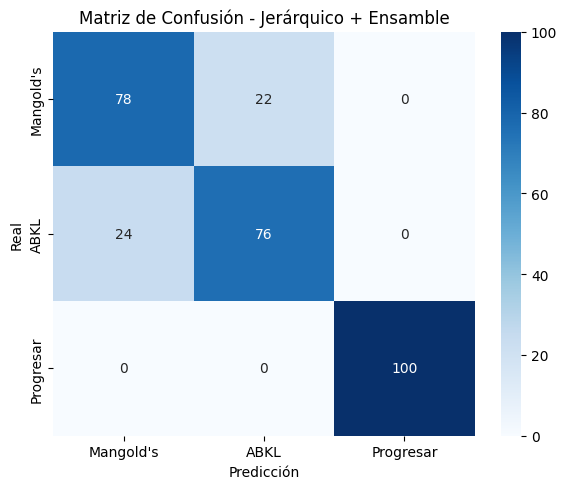

In [ ]:
# 🔁 CARGAR Y ENTRENAR MODELO JERÁRQUICO + ENSAMBLE

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# === SUBE TU ARCHIVO DESDE COLAB ===
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

# === FEATURE ENGINEERING AVANZADO ===
def prepare_advanced_data(df):
    X_raw = np.stack(df["Features"].apply(eval).values)
    correct = X_raw[:, 0:6]
    realized = X_raw[:, 6:12]
    errors = X_raw[:, 12]
    time = X_raw[:, 13]
    difficulty = X_raw[:, 14]

    error_rate = errors / 6
    similarity_score = np.sum(correct == realized, axis=1) / 6
    time_per_difficulty = time / difficulty
    omission_errors = np.sum((correct == 1) & (realized == 0), axis=1)
    addition_errors = np.sum((correct == 0) & (realized == 1), axis=1)
    error_balance_ratio = omission_errors / (addition_errors + 1e-5)
    time_per_error = time / (errors + 1)
    activation_density = np.sum(realized, axis=1) / 6
    speed_score = 1 / time

    X_enhanced = np.hstack((
        X_raw,
        error_rate.reshape(-1, 1),
        similarity_score.reshape(-1, 1),
        time_per_difficulty.reshape(-1, 1),
        omission_errors.reshape(-1, 1),
        addition_errors.reshape(-1, 1),
        error_balance_ratio.reshape(-1, 1),
        time_per_error.reshape(-1, 1),
        activation_density.reshape(-1, 1),
        speed_score.reshape(-1, 1)
    ))

    y = df["Label"].values
    return X_enhanced, y

# === PREPARACIÓN Y ESCALADO ===
X, y = prepare_advanced_data(df)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === ETAPA 1: Progresar vs No-Progresar ===
y_train_stage1 = (y_train == 2).astype(int)
y_test_stage1 = (y_test == 2).astype(int)
clf_stage1 = TabNetClassifier(seed=42, verbose=0)
clf_stage1.fit(X_train, y_train_stage1, max_epochs=100, patience=10, batch_size=256, virtual_batch_size=128)

# === ETAPA 2: Mangold vs ABKL ===
mask_train_2 = y_train != 2
mask_test_2 = y_test != 2
X_train_stage2 = X_train[mask_train_2]
y_train_stage2 = y_train[mask_train_2]
X_test_stage2 = X_test[mask_test_2]
y_test_stage2 = y_test[mask_test_2]

# TabNet
clf_tabnet_2 = TabNetClassifier(seed=42, verbose=0)
clf_tabnet_2.fit(X_train_stage2, y_train_stage2, max_epochs=100, patience=10, batch_size=256, virtual_batch_size=128)

# SVM
clf_svm_2 = SVC(probability=True)
clf_svm_2.fit(X_train_stage2, y_train_stage2)

# === PREDICCIÓN FINAL CON ENSAMBLE ===
def predict_ensemble_jerarquico(x):
    pred_stage1 = clf_stage1.predict(x.reshape(1, -1))[0]
    if pred_stage1 == 1:
        return 2
    else:
        p1 = clf_tabnet_2.predict_proba(x.reshape(1, -1))[0]
        p2 = clf_svm_2.predict_proba(x.reshape(1, -1))[0]
        avg = (p1 + p2) / 2
        return np.argmax(avg)

y_pred_final = np.array([predict_ensemble_jerarquico(x) for x in X_test])

# === REPORTES Y VISUALIZACIÓN ===
CLASSES = ["Mangold's", "ABKL", "Progresar"]
print("\n📊 Reporte de Clasificación - Modelo Jerárquico + Ensamble:\n")
print(classification_report(y_test, y_pred_final, target_names=CLASSES))

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Matriz de Confusión - Jerárquico + Ensamble")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


In [ ]:
# 🔧 INSTALACIÓN DE DEPENDENCIAS (EJECUTAR PRIMERO)
!pip install --quiet pytorch-tabnet
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install --quiet scikit-learn seaborn pandas matplotlib

Saving balanced_braille_data.csv to balanced_braille_data (2).csv


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



📊 Reporte de Clasificación - Final:

              precision    recall  f1-score   support

   Mangold's       0.71      0.75      0.73       100
        ABKL       0.73      0.69      0.71       100
   Progresar       1.00      1.00      1.00       100

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



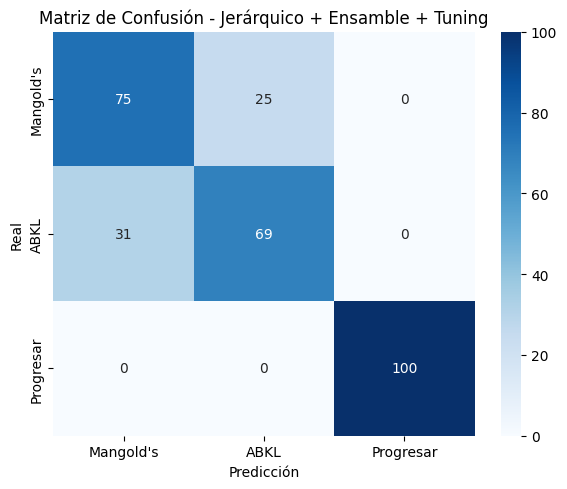

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔁 PIPELINE COMPLETO: features avanzadas + TabNet + SVM + jerárquico + errores

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# === SUBE TU ARCHIVO CSV ===
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))  # Carga el archivo

# === EXTRAER FEATURES AVANZADAS ===
def prepare_advanced_data(df):
    X_raw = np.stack(df["Features"].apply(eval).values)
    correct = X_raw[:, 0:6]
    realized = X_raw[:, 6:12]
    errors = X_raw[:, 12]
    time = X_raw[:, 13]
    difficulty = X_raw[:, 14]

    error_rate = errors / 6
    similarity_score = np.sum(correct == realized, axis=1) / 6
    time_per_difficulty = time / (difficulty + 1e-5)
    omission_errors = np.sum((correct == 1) & (realized == 0), axis=1)
    addition_errors = np.sum((correct == 0) & (realized == 1), axis=1)
    error_balance_ratio = omission_errors / (addition_errors + 1e-5)
    time_per_error = time / (errors + 1)
    activation_density = np.sum(realized, axis=1) / 6
    speed_score = 1 / time

    X_enhanced = np.hstack((
        X_raw,
        error_rate.reshape(-1, 1),
        similarity_score.reshape(-1, 1),
        time_per_difficulty.reshape(-1, 1),
        omission_errors.reshape(-1, 1),
        addition_errors.reshape(-1, 1),
        error_balance_ratio.reshape(-1, 1),
        time_per_error.reshape(-1, 1),
        activation_density.reshape(-1, 1),
        speed_score.reshape(-1, 1)
    ))

    y = df["Label"].values
    return X_enhanced, y

# === PREPARAR DATOS ===
X, y = prepare_advanced_data(df)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# === ETAPA 1: TabNet para Progresar vs No-Progresar
y_train_bin = (y_train == 2).astype(int)
y_test_bin = (y_test == 2).astype(int)

clf_stage1 = TabNetClassifier(seed=42, verbose=0)
clf_stage1.fit(X_train, y_train_bin, max_epochs=100, patience=10, batch_size=256)

# === ETAPA 2: SVM + TabNet para ABKL vs Mangold's
mask_train_2 = y_train != 2
mask_test_2 = y_test != 2
X_train_stage2 = X_train[mask_train_2]
y_train_stage2 = y_train[mask_train_2]
X_test_stage2 = X_test[mask_test_2]
y_test_stage2 = y_test[mask_test_2]

# TabNet
clf_tabnet_2 = TabNetClassifier(seed=42, verbose=0)
clf_tabnet_2.fit(X_train_stage2, y_train_stage2, max_epochs=100, patience=10, batch_size=256)

# SVM con tuning
svm = SVC(class_weight={0: 1.2, 1: 1.0}, probability=True)
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
grid = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train_stage2, y_train_stage2)
svm_best = grid.best_estimator_

# === PREDICCIÓN FINAL CON ENSAMBLE SUAVE ===
def predict_ensemble_jerarquico(x):
    pred_stage1 = clf_stage1.predict(x.reshape(1, -1))[0]
    if pred_stage1 == 1:
        return 2
    else:
        p1 = clf_tabnet_2.predict_proba(x.reshape(1, -1))[0]
        p2 = svm_best.predict_proba(x.reshape(1, -1))[0]
        avg = (p1 + p2) / 2
        return np.argmax(avg)

y_pred_final = np.array([predict_ensemble_jerarquico(x) for x in X_test])

# === REPORTES Y MATRIZ ===
CLASSES = ["Mangold's", "ABKL", "Progresar"]
print("\n📊 Reporte de Clasificación - Final:\n")
print(classification_report(y_test, y_pred_final, target_names=CLASSES))

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Matriz de Confusión - Jerárquico + Ensamble + Tuning")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === ANÁLISIS DE ERRORES ===
errores = pd.DataFrame({
    "Real": y_test,
    "Predicho": y_pred_final,
    "Correcto": y_test == y_pred_final
})
errores.to_csv("errores_clasificacion.csv", index=False)
files.download("errores_clasificacion.csv")
